**SEGMENTING AND CLUSTERING NEIGHBORHOODS IN TORONTO**

**INTRODUCTION**

We will convert addresses to their equivalent latitude and longitude values.Use the Foursquare API to explore neighborhoods in the city of Toronto. We will use the explore function to obtain the most common location categories in each neighborhood, then group the neighborhoods with the k-means clustering algorithm and finally use the Folium library to view Toronto city neighborhoods and its emerging clusters.

**PART 1. WEB SCRAPPING THE DATA**

Let's retrieve URL and create a Beautiful soup object

In [43]:
!pip install bs4

In [45]:
URL = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M" #save the URL of the webpage with a name

In [166]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json # library to handle JSON files
!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.datasets.samples_generator import make_blobs
!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
from bs4 import BeautifulSoup
import lxml
print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


In [167]:
source= requests.get(URL).text

In [48]:
soup = BeautifulSoup(source, 'lxml')

In [49]:
table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

# print(table_contents)
df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})


In [50]:
df

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government
5,M9A,Etobicoke,Islington Avenue
6,M1B,Scarborough,"Malvern, Rouge"
7,M3B,North York,Don Mills North
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


In [11]:
df['PostalCode'].duplicated().sum()

0

In [12]:
df.shape

(103, 3)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   PostalCode    103 non-null    object
 1   Borough       103 non-null    object
 2   Neighborhood  103 non-null    object
dtypes: object(3)
memory usage: 2.5+ KB


Group all neighborhoods with the same postal code

In [51]:
df = df.groupby(["PostalCode", "Borough"])["Neighborhood"].apply(", ".join).reset_index()
df.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [15]:
df.shape

(103, 3)

**PART 2: GETTING THE LATITUDE AND LONGITUDE OF EACH POSTAL_CODE**

**Get the coordinates of each neighborhood of Toronto**

Now that you have built a dataframe of the postal code of each neighborhood along with the borough name and neighborhood name, in order to utilize the Foursquare location data, we need to get the latitude and the longitude coordinates of each neighborhood. 

In [52]:
#read geospatial data file
df2= pd.read_csv("Geospatial_Coordinates.csv")
df2.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [53]:
# Renamed the columns
df2=df2.rename(columns={'Postal Code':'PostalCode'} )

Both df and df2 dataframes can be merged into a single data frame (df3)

In [54]:
df3 = pd.merge(df, df2, on=["PostalCode"], how="inner")

df3.head(12)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"Kennedy Park, Ionview, East Birchmount Park",43.727929,-79.262029
7,M1L,Scarborough,"Golden Mile, Clairlea, Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848


In [55]:
print(f"The dataframe has {len(df3['Borough'].unique())} boroughs")

The dataframe has 15 boroughs


In [56]:
df3[["Borough"]].value_counts()

Borough               
North York                24
Scarborough               17
Downtown Toronto          17
Etobicoke                 11
Central Toronto            9
West Toronto               6
York                       5
East York                  4
East Toronto               4
Queen's Park               1
Mississauga                1
Etobicoke Northwest        1
East York/East Toronto     1
East Toronto Business      1
Downtown Toronto Stn A     1
dtype: int64

**PART 3: CLUSTERING THE NEIGHBORHOODS IN TORONTO**

In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent to_explorer, as shown below.

In [123]:
address = 'Toronto, Canada'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto, Canada are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto, Canada are 43.6534817, -79.3839347.


**Create a map of Toronto with neighborhoods superimposed on top.**

In [127]:
# create map of New York using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df3['Latitude'], df3['Longitude'], df3['Borough'], df3['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='purple',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

**Define Foursquare Credentials and Version**

In [129]:
CLIENT_ID = '4RXRYTQPQVF0LDHKKBYNQOYIYTW414B03I2IJCMCRXR2QLQC' # your Foursquare ID
CLIENT_SECRET = '5MOFV0LBDKO5CZV3FHL2UUTAQQQ3AAPBZAPIHWOHFHVHBJTZ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 4RXRYTQPQVF0LDHKKBYNQOYIYTW414B03I2IJCMCRXR2QLQC
CLIENT_SECRET:5MOFV0LBDKO5CZV3FHL2UUTAQQQ3AAPBZAPIHWOHFHVHBJTZ


**Let's explore the first neighborhood in our dataframe.**

Get the neighborhood's name.

In [132]:
df3.loc[0, 'Neighborhood']

'Malvern, Rouge'

Get the neighborhood's latitude and longitude values.

In [133]:
neighborhood_latitude =df3.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df3.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = df3.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Malvern, Rouge are 43.806686299999996, -79.19435340000001.


**Now, let's get the top 100 venues that are in Malvern, Rouge within a radius of 500 meters.**

First, let's create the GET request URL. Name your URL url.

In [135]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=4RXRYTQPQVF0LDHKKBYNQOYIYTW414B03I2IJCMCRXR2QLQC&client_secret=5MOFV0LBDKO5CZV3FHL2UUTAQQQ3AAPBZAPIHWOHFHVHBJTZ&v=20180605&ll=43.806686299999996,-79.19435340000001&radius=500&limit=100'

Send the GET request and examine the resutls

In [136]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '61076127a33091181ebba07f'},
 'response': {'warning': {'text': "There aren't a lot of results near you. Try something more general, reset your filters, or expand the search area."},
  'headerLocation': 'Malvern',
  'headerFullLocation': 'Malvern, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 1,
  'suggestedBounds': {'ne': {'lat': 43.8111863045, 'lng': -79.18812958073042},
   'sw': {'lat': 43.80218629549999, 'lng': -79.2005772192696}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4bb6b9446edc76b0d771311c',
       'name': 'Wendy’s',
       'location': {'crossStreet': 'Morningside & Sheppard',
        'lat': 43.80744841934756,
        'lng': -79.19905558052072,
        'labeledLatLngs': [{'label': 'display'

In [138]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a pandas dataframe.

In [140]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = pd.json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Wendy’s,Fast Food Restaurant,43.807448,-79.199056


And how many venues were returned by Foursquare?

In [141]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

1 venues were returned by Foursquare.


**EXPLORE NEIGHBORDHOODS IN TORONTO**

**Let's create a function to repeat the same process to all the neighborhoods.**

In [142]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

**Now write the code to run the above function on each neighborhood and create a new dataframe called toronto_venues.**

In [144]:
toronto_venues = getNearbyVenues(names=df3['Neighborhood'],
                                   latitudes=df3['Latitude'],
                                   longitudes=df3['Longitude']
                                  )

Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Don Mills South
Bathurst Manor, Wilson Heights, Downsview North
Northwood Park, York University
Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Parkview Hill, Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
The Danforth  East
The Danforth West, Riverdale


print(toronto_venues.shape)
toronto_venues.head()**Let's check the size of the resulting dataframe**

In [145]:
print(toronto_venues.shape)
toronto_venues.head()

(2141, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Malvern, Rouge",43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
1,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,"Guildwood, Morningside, West Hill",43.763573,-79.188711,RBC Royal Bank,43.766790,-79.191151,Bank
3,"Guildwood, Morningside, West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Sail Sushi,43.765951,-79.191275,Restaurant


Let's check how many venues were returned for each neighborhood

In [105]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,3,3,3,3,3,3
"Alderwood, Long Branch",7,7,7,7,7,7
"Bathurst Manor, Wilson Heights, Downsview North",22,22,22,22,22,22
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",23,23,23,23,23,23
Berczy Park,57,57,57,57,57,57
"Birch Cliff, Cliffside West",4,4,4,4,4,4
"Brockton, Parkdale Village, Exhibition Place",27,27,27,27,27,27
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",17,17,17,17,17,17


Finding the number of unique categories:

In [146]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 271 uniques categories.


**ANALYZE EACH NEIGHBORHOOD**

In [148]:
#one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.shape

(2141, 271)

**Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category**

In [149]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Yoga Studio,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Carpet Store,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Service,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Knitting Store,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Social Club,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stadium,Stationery Store,Steakhouse,Strip Club,Summer Camp,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

**Let's print each neighborhood along with the top 10 most common venues**

In [150]:
num_top_venues = 10

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                        venue  freq
0                      Lounge  0.33
1              Breakfast Spot  0.33
2   Latin American Restaurant  0.33
3                 Yoga Studio  0.00
4               Metro Station  0.00
5  Modern European Restaurant  0.00
6           Mobile Phone Shop  0.00
7          Miscellaneous Shop  0.00
8   Middle Eastern Restaurant  0.00
9          Mexican Restaurant  0.00


----Alderwood, Long Branch----
                        venue  freq
0                 Pizza Place  0.29
1                         Pub  0.14
2              Sandwich Place  0.14
3                         Gym  0.14
4                Dance Studio  0.14
5                 Coffee Shop  0.14
6  Modern European Restaurant  0.00
7           Mobile Phone Shop  0.00
8          Miscellaneous Shop  0.00
9   Middle Eastern Restaurant  0.00


----Bathurst Manor, Wilson Heights, Downsview North----
                       venue  freq
0                       Bank  0.09
1                Coffee Shop 

**Let's put that into a pandas dataframe**

First, let's write a function to sort the venues in descending order.

In [151]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)

    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [152]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Lounge,Latin American Restaurant,Breakfast Spot,Drugstore,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Eastern European Restaurant
1,"Alderwood, Long Branch",Pizza Place,Gym,Coffee Shop,Sandwich Place,Pub,Dance Studio,Comic Shop,Dim Sum Restaurant,Escape Room,Electronics Store
2,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Bank,Park,Shopping Mall,Bridal Shop,Sandwich Place,Restaurant,Pizza Place,Pharmacy,Mobile Phone Shop
3,Bayview Village,Café,Bank,Chinese Restaurant,Japanese Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Women's Store
4,"Bedford Park, Lawrence Manor East",Sandwich Place,Italian Restaurant,Coffee Shop,Comfort Food Restaurant,Thai Restaurant,Juice Bar,Fast Food Restaurant,Butcher,Restaurant,Café


**CLUSTERING DOWNTOWN NEIGHBORHOODS**

Run k-means to cluster the neighborhood into 5 clusters.

In [183]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1], dtype=int32)

In [187]:
neighborhoods_venues_sorted.drop(['Cluster Labels'], axis=1, inplace=True)

In [188]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df3

# merge toronto_grouped with df3 to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

# check the last columns!
toronto_merged.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353,0.0,Fast Food Restaurant,Dessert Shop,Event Space,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,4.0,Bar,Women's Store,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Drugstore,Farmers Market
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,0.0,Medical Center,Electronics Store,Breakfast Spot,Restaurant,Rental Car Location,Mexican Restaurant,Donut Shop,Bank,Intersection,Distribution Center
3,M1G,Scarborough,Woburn,43.770992,-79.216917,0.0,Coffee Shop,Indian Restaurant,Korean BBQ Restaurant,Drugstore,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,0.0,Caribbean Restaurant,Gas Station,Bank,Fried Chicken Joint,Athletics & Sports,Thai Restaurant,Bakery,Hakka Restaurant,Dumpling Restaurant,Drugstore


In [196]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        #color=rainbow[cluster-1],
        fill=True,
        #fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

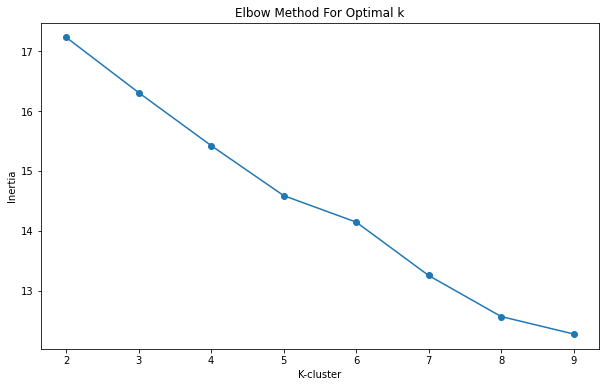

In [193]:
# Lista de valores de K
Kclusters = range(2, 10)

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# Lista para as métricas
valores_metrica = []

# Loop por diferentes modelos com diferentes valores de K
for K in Kclusters:
    modelo = KMeans(n_clusters = K, random_state = 101)
    modelo.fit(toronto_grouped_clustering)
    valores_metrica.append(modelo.inertia_)
    
plt.figure(figsize=(10, 6))
plt.plot(Kclusters, valores_metrica, 'o-')
plt.xlabel("K-cluster")
plt.ylabel("Inertia")
plt.title('Elbow Method For Optimal k')
plt.show()

**Examining the clusters**

Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster. I will leave this exercise to you.

In [198]:
cluster_1=toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, 
                            toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
cluster_1

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Scarborough,0.0,Fast Food Restaurant,Dessert Shop,Event Space,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop
2,Scarborough,0.0,Medical Center,Electronics Store,Breakfast Spot,Restaurant,Rental Car Location,Mexican Restaurant,Donut Shop,Bank,Intersection,Distribution Center
3,Scarborough,0.0,Coffee Shop,Indian Restaurant,Korean BBQ Restaurant,Drugstore,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
4,Scarborough,0.0,Caribbean Restaurant,Gas Station,Bank,Fried Chicken Joint,Athletics & Sports,Thai Restaurant,Bakery,Hakka Restaurant,Dumpling Restaurant,Drugstore
6,Scarborough,0.0,Department Store,Discount Store,Bus Station,Coffee Shop,Women's Store,Donut Shop,Distribution Center,Dog Run,Doner Restaurant,Drugstore
7,Scarborough,0.0,Bakery,Bus Line,Park,Intersection,Metro Station,Bus Station,Ice Cream Shop,Women's Store,Distribution Center,Dog Run
8,Scarborough,0.0,American Restaurant,Motel,Department Store,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Women's Store
9,Scarborough,0.0,College Stadium,Skating Rink,Café,General Entertainment,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run
10,Scarborough,0.0,Indian Restaurant,Vietnamese Restaurant,Chinese Restaurant,Pet Store,Eastern European Restaurant,Electronics Store,Dumpling Restaurant,Drugstore,Donut Shop,Department Store
11,Scarborough,0.0,Middle Eastern Restaurant,Smoke Shop,Bakery,Sandwich Place,Doner Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Women's Store


In [199]:
cluster_2=toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, 
                            toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
cluster_2


,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Scarborough,0.0,Fast Food Restaurant,Dessert Shop,Event Space,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop
2,Scarborough,0.0,Medical Center,Electronics Store,Breakfast Spot,Restaurant,Rental Car Location,Mexican Restaurant,Donut Shop,Bank,Intersection,Distribution Center
3,Scarborough,0.0,Coffee Shop,Indian Restaurant,Korean BBQ Restaurant,Drugstore,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
4,Scarborough,0.0,Caribbean Restaurant,Gas Station,Bank,Fried Chicken Joint,Athletics & Sports,Thai Restaurant,Bakery,Hakka Restaurant,Dumpling Restaurant,Drugstore
6,Scarborough,0.0,Department Store,Discount Store,Bus Station,Coffee Shop,Women's Store,Donut Shop,Distribution Center,Dog Run,Doner Restaurant,Drugstore
7,Scarborough,0.0,Bakery,Bus Line,Park,Intersection,Metro Station,Bus Station,Ice Cream Shop,Women's Store,Distribution Center,Dog Run
8,Scarborough,0.0,American Restaurant,Motel,Department Store,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Women's Store
9,Scarborough,0.0,College Stadium,Skating Rink,Café,General Entertainment,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run
10,Scarborough,0.0,Indian Restaurant,Vietnamese Restaurant,Chinese Restaurant,Pet Store,Eastern European Restaurant,Electronics Store,Dumpling Restaurant,Drugstore,Donut Shop,Department Store
11,Scarborough,0.0,Middle Eastern Restaurant,Smoke Shop,Bakery,Sandwich Place,Doner Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Women's Store


In [201]:
cluster_3=toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, 
                            toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
cluster_3

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Scarborough,2.0,Playground,Women's Store,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Drugstore


In [202]:
cluster_4=toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
cluster_4

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
94,Etobicoke,3.0,Filipino Restaurant,Women's Store,Drugstore,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant


In [ ]:
cluster_4=toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
cluster_4